In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Reading in the training data, 1.1MB file so let's just read in the whole thing to take a look. _baseline.py_ has a nice function to read it into a dict but I prefer pandas.

In [4]:
train = pd.read_csv('./../data/train.csv')

In [20]:
train.sample(10)

,category,text
5359,personal,"I just wanted friends, not let me annoy the sh..."
8199,personal,I try to be positive and maintain happy becaus...
2501,lgbtq,22 lesbian stud. Wants a girl to chill and wat...
3977,family,Why is it so hard to find someone that underst...
7699,relationships,So tired of this separation thing I miss being...
10334,personal,I self harm and my parents dont even know it...
13472,food,Food!
8074,school,I swear math makes me want to drop out of coll...
5196,personal,People say life gives you what you deserve. Ei...
6526,fashion,There needs to be above the knee socks for gir...


In [7]:
train.shape

(14048, 2)

14,048 messages with a category outcome. How many categories in the training set?

In [10]:
len(train.category.unique())

17

And what's the category prevalence in the training set like, for these 17 categories...

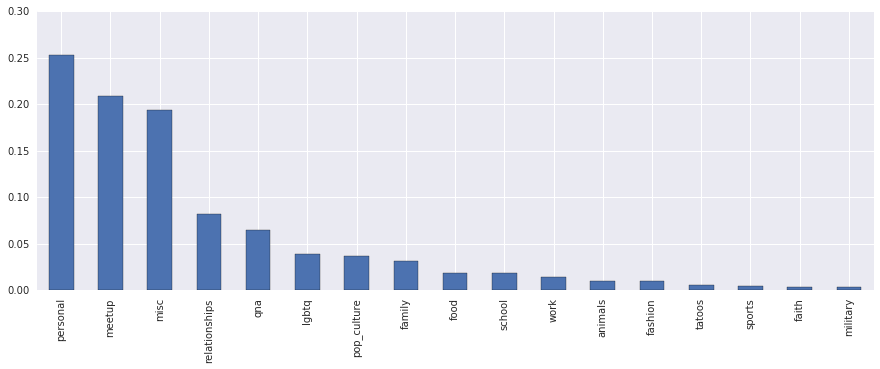

In [19]:
train.category.value_counts(normalize=True).plot(kind='bar', figsize=(15,5))

We have an imbalance problem! 5 categories account for almost 80% of the training set. Any classifier we train won't learn to distinguish the remaining 12 categories very well.

## 1. Message Length  

Do message lengths (# of words) clue us into categories?

In [66]:
#with stopwords
train['num_words']=train['text'].apply(lambda msg: len(str(msg).decode('utf8').split(' ')))
#train.text[5].split(' ')

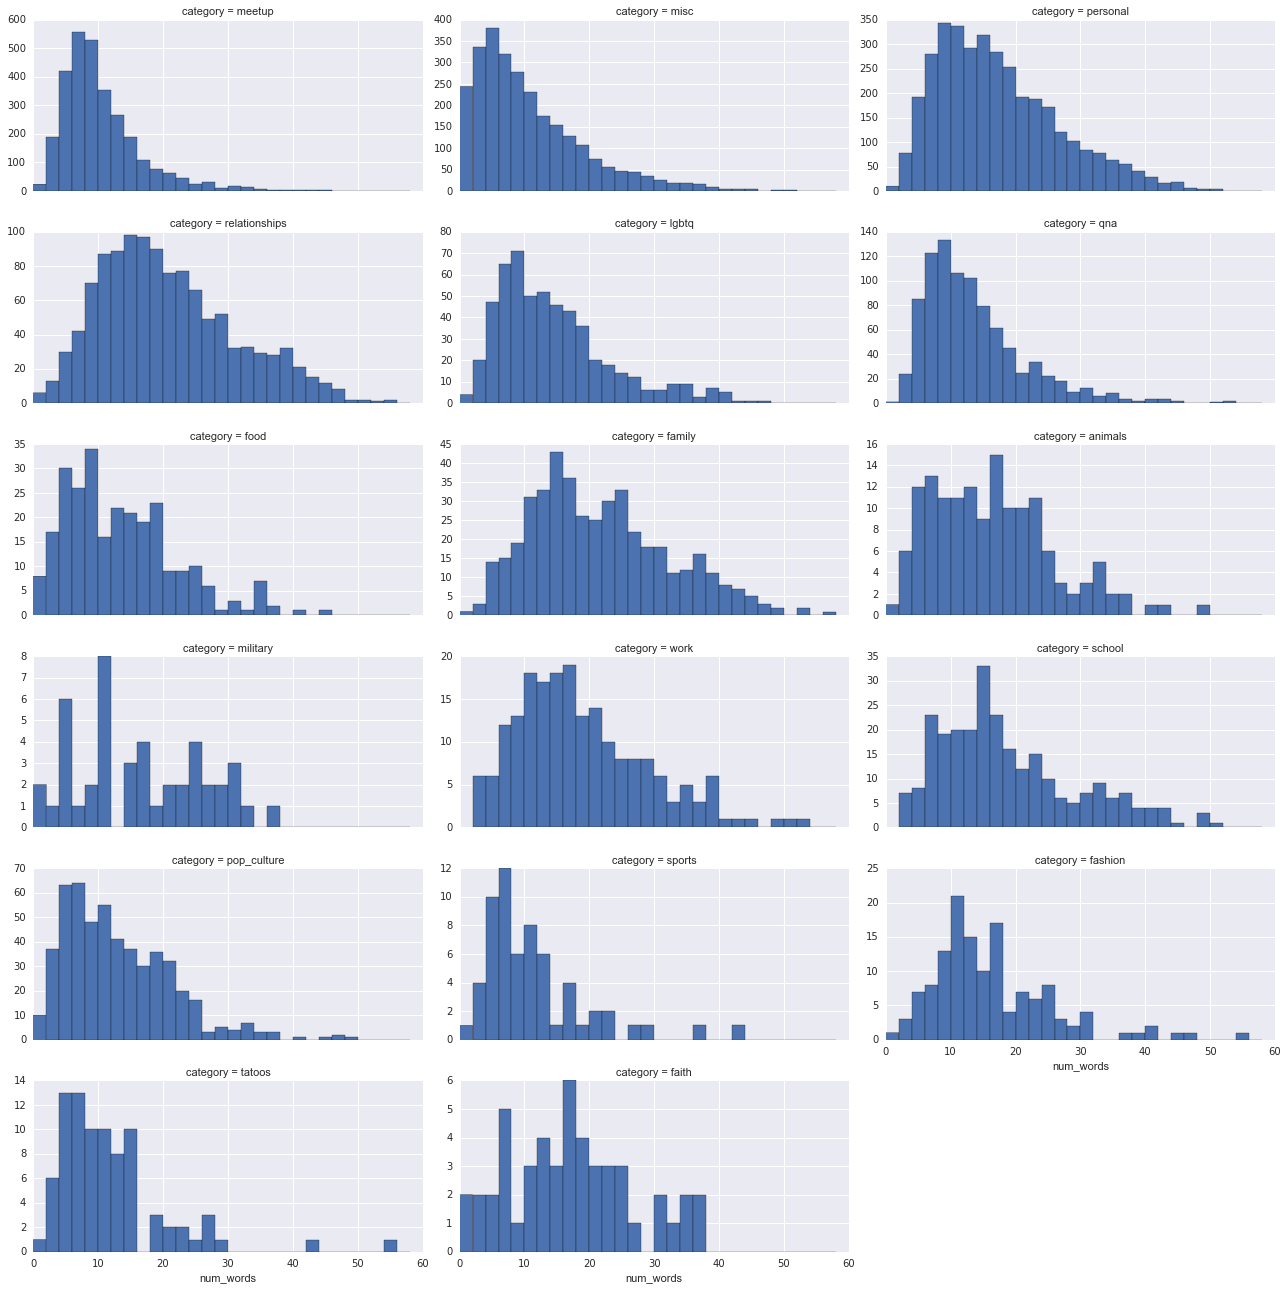

In [94]:
g = sns.FacetGrid(train, col='category', size=3, aspect=2, col_wrap=3, sharey=False)
g = g.map(plt.hist, 'num_words', bins=np.arange(0,60,2))

We see that the distribution of the number of words (including stopwords) does vary by categories, some more than the other. This might be a decent predictor at least between categories that are prone to short messages (ex. "misc", "meetup", or "tattoos" versus those that tend towards being more wordy such as "school", "family", or "relationships". 

---  

## 2. Emoji Prevalence  

What about the prevalence of common **emojis**? Can the usage of emojis clue us in to certain categories?

In [1]:
train['num_emojis']=train.text.str.count(':[-\)]|:[-\(]|:[-Dd]|:[-Pp]|:[-o0O]|:[-\\\/]|:[-$*@]|:smile:|:hug:|[<>]3|;[\)]')

NameError: name 'train' is not defined

Calculate the prevalence of emojis across the total number of messages within each class.

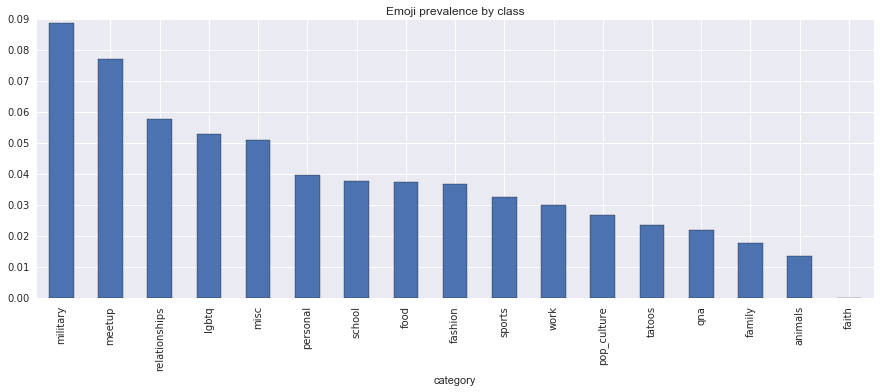

In [135]:
(train.groupby(by='category')['num_emojis'].sum()/train.groupby(by='category').size()).sort_values(ascending=False).plot(kind='bar', figsize=(15,5))
plt.title('Emoji prevalence by class')

Interesting results! We notice that classes tending toward social interaction, such as "military", "meetup", "relationships", "lgbtq", "misc", "personal", "school" tend to see a higher usage of emojis. Perhaps this alludes to the dominant age group of the class or the nature of the interactions, or both. Nevertheless, Emoji prevalence might be a very good predictor. 

> Although this is an interesting insight, *emoji prevalence* **cannot** be used as-is as a feature in this exercise because of problems with validating the prevalence against unseen holdout data. **One possible way to incorporate this into the ML exercise could be to add a bunch of features during the tokenization exercise that represent a *bag of emojis* - a tedious exercise, but one that might help the classifier discern classes well, as seen in the figure above.**  

**For the final model, I've incorporated an emoji vocabulary of 10 common emojis.**

--- 

## 3. Sentiment Analysis  

Does message *sentiment* clue us into the categories? How about their subjectivity? Let's use the *TextBlob* package's generic sentiment scorer, to start with.

In [139]:
from textblob import TextBlob

In [169]:
train['polarity']=train.text.apply(lambda msg: TextBlob(str(msg).decode('utf-8')).sentiment[0])
train['subjectivity']=train.text.apply(lambda msg: TextBlob(str(msg).decode('utf-8')).sentiment[1])
train['sentiment']=np.where(train['polarity']>0, 'positive','negative') #for visualizing
train['sentiment']=np.where(train['polarity']==0, 'neutral',train['sentiment']) #for visualizing

In [170]:
pd.set_option('max_colwidth',150)
train[['text','polarity','subjectivity','sentiment']].sample(10)

,text,polarity,subjectivity,sentiment
1490,Trying to do this rubiks cube I'm getting mad,-0.625000,1.000000,negative
661,Any ladies wanna drink?,0.000000,0.000000,neutral
6917,I met a guy on here a couple weeks ago and I really want to meet him in person.,0.200000,0.200000,positive
10847,"So bored in hartlepool, there'sfuck all to do",-0.500000,1.000000,negative
11501,I wonder if it's possible to create a new Playstation Network Account.,0.068182,0.727273,positive
12026,Stop acting like the world owes you shit the world don't woe you shit EARN what you want Stop asking for fucking handouts You lazy fucks,-0.250000,0.680000,negative
8988,I can't remember the last time I left the house without makeup on. I'm a guy..,0.000000,0.033333,neutral
4769,I don't understand why I never had a bf or a first kiss...,0.250000,0.333333,positive
9878,I'm nothing but a letdown,0.000000,0.000000,neutral
5595,"If I take care of myself, why doesn't the urge go away?",0.000000,0.000000,neutral


While not perfect, the package sentiment and subjectivity scorer does a decent job. Subsequent iterations can train mroe personalizes sentiment models. How does sentiment (polarity) of messages vary by class?

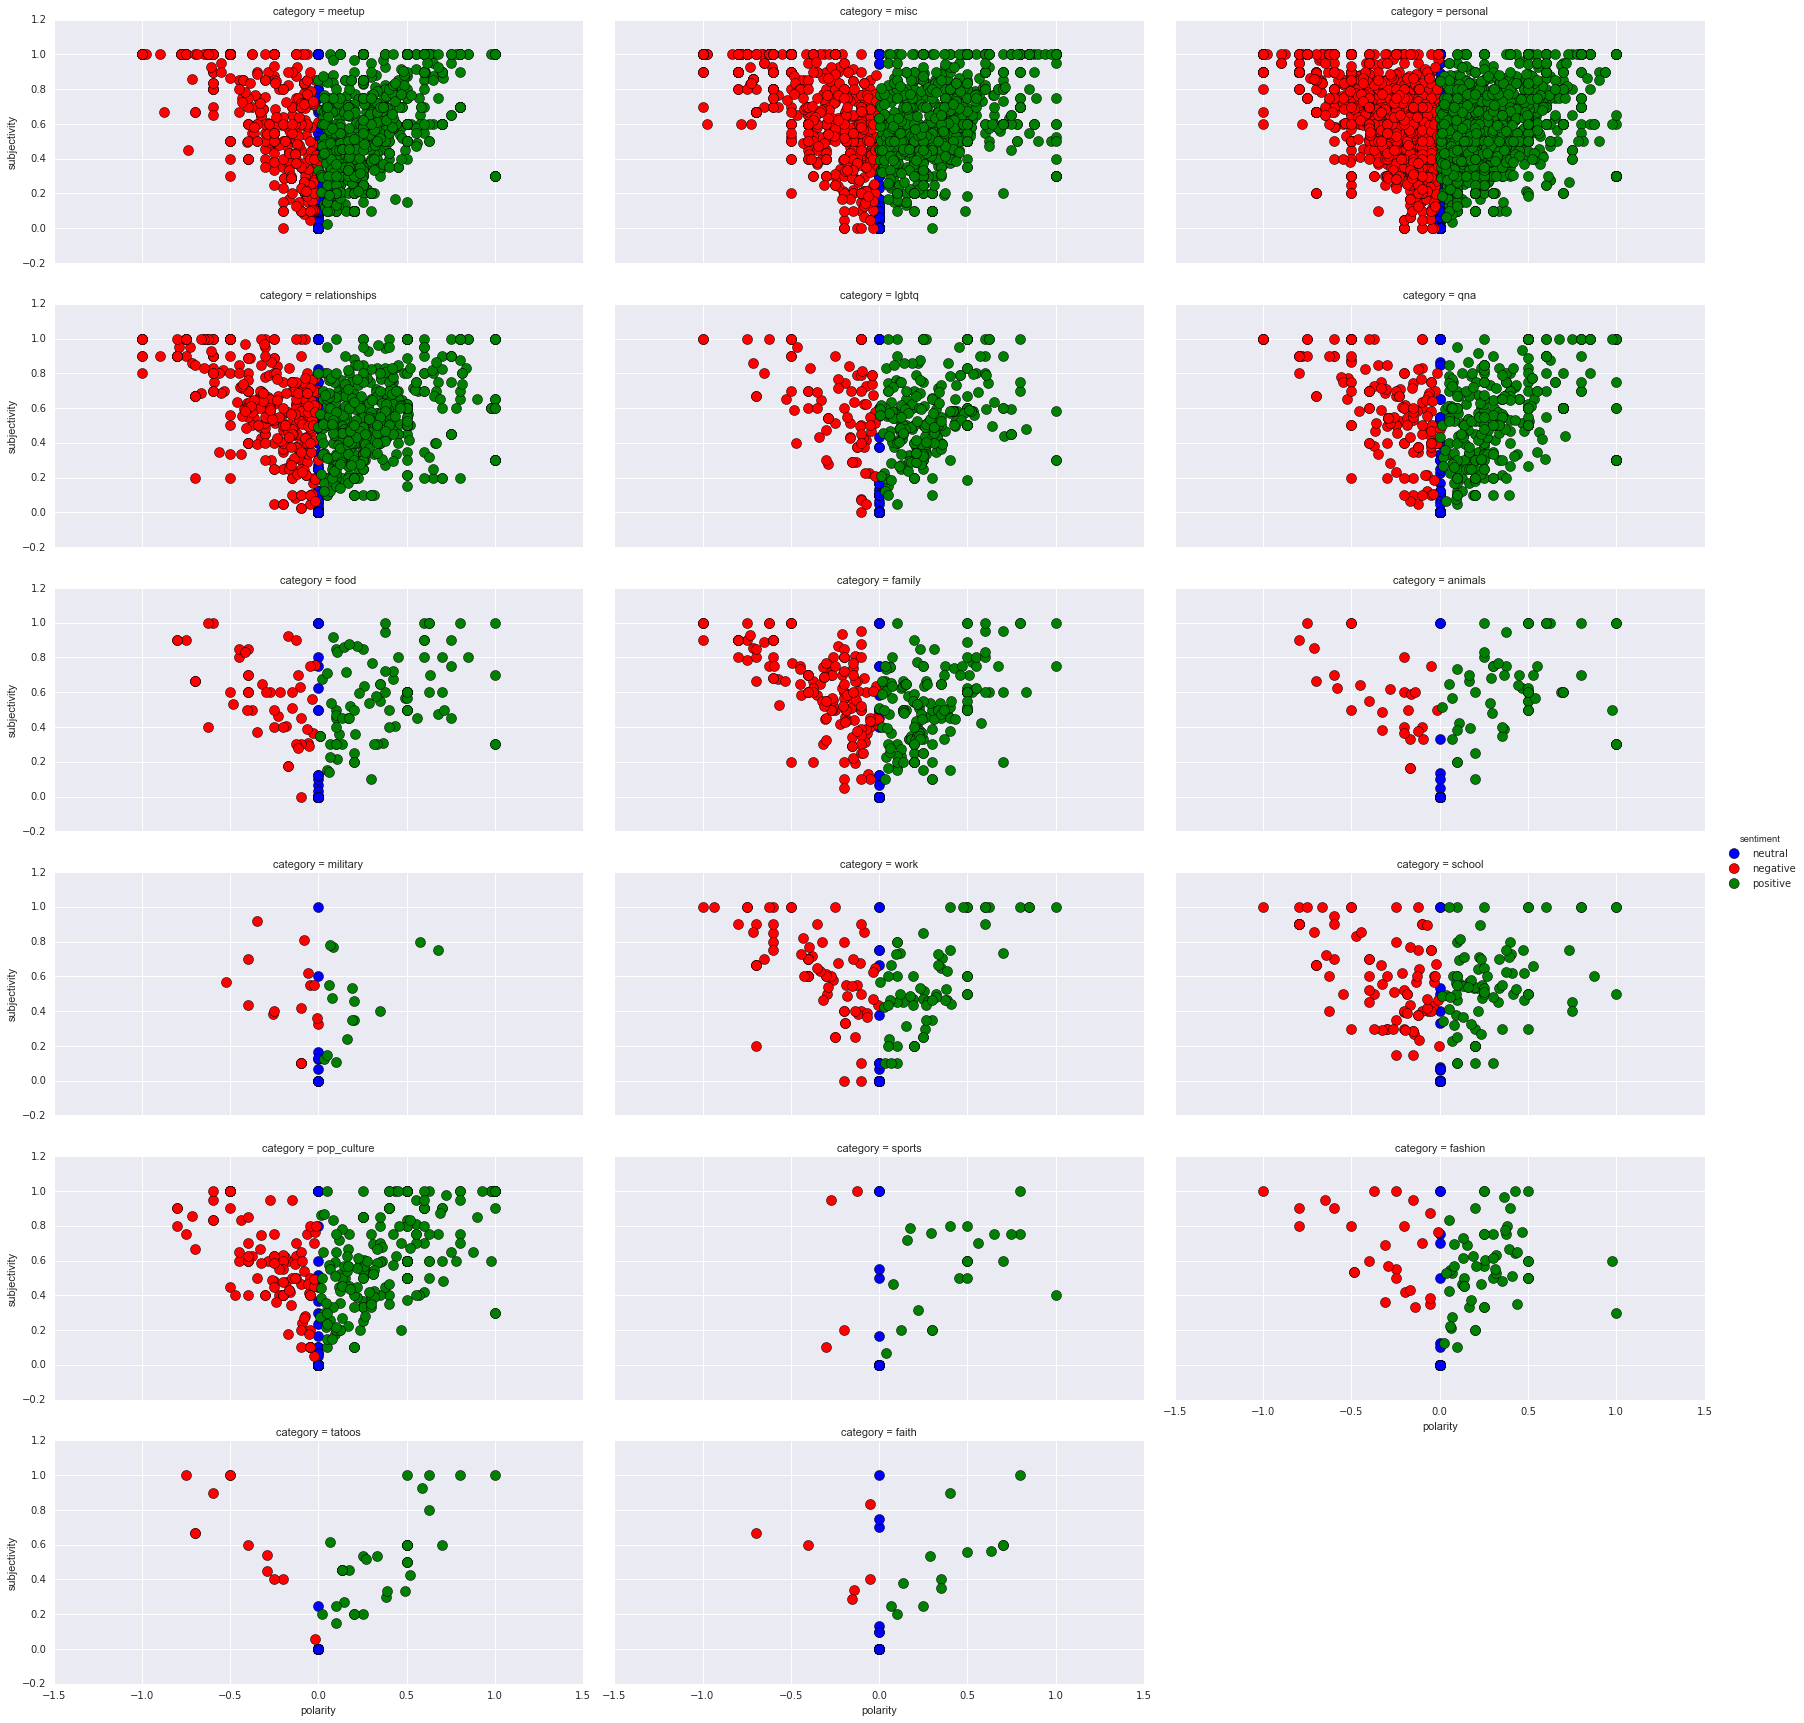

In [180]:
kws = dict(s=100, linewidth=.5, edgecolor="black")

g = sns.FacetGrid(train, col='category', size=4, aspect=2, col_wrap=3, 
                  sharey=True, sharex=True, hue='sentiment', palette=['blue','red','green'])
g = g.map(plt.scatter, 'polarity', 'subjectivity', **kws)
g.add_legend()

There are some catgories where sentiment (not a perfect score itself) seems to be able to discren well, for example: "lgbtq" sees more positive sentiments that are moderately subjective, as does "tatoos", "faith" and "sports". The sparse classes seem to see a clearer distinction of sentiment. Subjectivity isn't very helpful as polarity is. Improving the sentiment accuracy by training on a curated lexicon specific to this space might sharply improve the discerning power of this feature.

---  

## 4. Parts of Speech Analysis

In [216]:
parts={
    'CC':0,
    'CD':0,
    'DT':0,
    'EX':0,
    'FW':0,
    'IN':0,
    'JJ':0,
    'JJR':0,
    'JJS':0,
    'LS':0,
    'MD':0,
    'NN':0,
    'NNS':0,
    'NNP':0,
    'NNPS':0,
    'PDT':0,
    'POS':0,
    'PRP':0,
    'PRP$':0,
    'RB':0,
    'RBR':0,
    'RBS':0,
    'RP':0,
    'SYM':0,
    'TO':0,
    'UH':0,
    'VB':0,
    'VBD':0,
    'VBG':0,
    'VBN':0,
    'VBP':0,
    'VBZ':0,
    'WDT':0,
    'WP':0,
    'WP$':0,
    'WRB':0}




for key in parts.keys():
    train[key]=0


for i in np.arange(0,train.shape[0]-1):
    for word,pos in TextBlob(str(train.text[i]).decode('utf-8')).tags:
        train.loc[i,pos] += 1


In [220]:
pd.set_option('max_columns',100)
train.sample(3)

,category,text,num_words,num_punct,num_emojis,polarity,subjectivity,sentiment,WRB,PRP$,VBG,FW,CC,PDT,RBS,PRP,CD,WP$,VBP,VBN,EX,JJ,IN,WP,VBZ,DT,MD,NNPS,RP,NN,POS,RBR,VBD,JJS,JJR,SYM,VB,TO,UH,LS,RB,WDT,NNS,NNP
8885,relationships,I'm fucking done with my boyfriend ... First of all I he is cheating on me and then he says I'm fucking cheating on him...,25,123.0,0.0,-0.316667,0.644444,negative,0,1,4,0,1,0,0,7,0,0,2,1,0,0,4,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
8358,personal,Its to the point i don't want to hang out with my friends They just get hit on or talk about boys who flirt with them I'm to embarrassed to say no...,42,191.0,0.0,0.000000,0.000000,neutral,0,2,0,0,2,0,0,5,0,0,4,3,0,0,6,1,1,2,0,0,1,3,0,0,0,0,0,0,4,4,0,0,3,0,3,0
4929,meetup,Any ladies want to just chat,6,29.0,0.0,0.000000,0.000000,neutral,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0


In [241]:
train['adjectives'] = np.sum(train[['JJ','JJR','JJS']], axis=1)
train['verbs'] = np.sum(train[['VB','VBG','VBD','VBN','VBP','VBZ']], axis=1)
train['prop_nouns'] = np.sum(train[['NNP','NNPS']], axis=1)

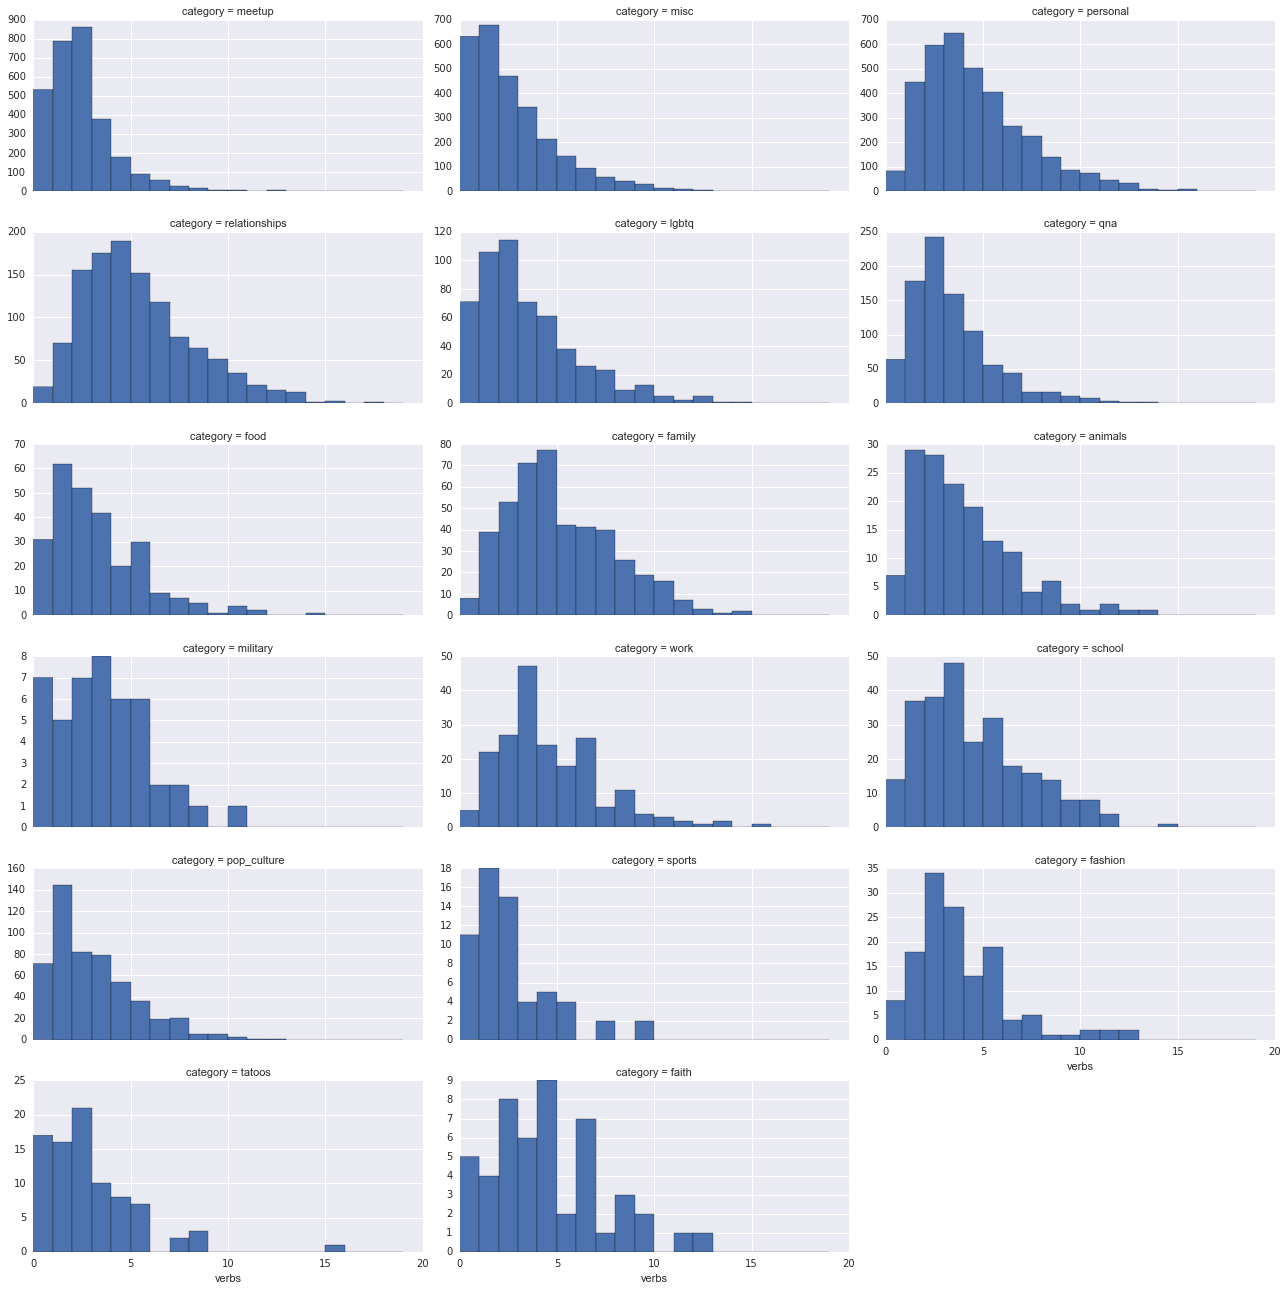

In [249]:
#visualize parts of speech densities by class
#kws = dict(s=100, linewidth=.5, edgecolor="black")

#plot hist adjectives, verbs, nouns
g = sns.FacetGrid(train, col='category', size=3, aspect=2, col_wrap=3, 
                  sharey=False, sharex=True)
g = g.map(plt.hist, 'verbs', bins=np.arange(0,20,1))
#g.add_legend()

Adjectives: Mostly right skewed but "fashion", "family", "military" do tend to see more adjectives per message.  
Verbs (base form): definitely sees some variation between classes
Proper Nouns: "pop_culture", "sports", "meetups" do see the use of more proper nouns 

Did not check other POS such as *adverbs*, *prepositions*, etc. but the POS composition of messages might clue us into the category. **We'll preserve each POS as a feature in our vector space.**


## Future Implementation for POS Tagging: 

On subsequent iterations, I'd like to use the Parts of Speech to formulate more meaningful n-gram structures instead of brute-force n-gram permutations (which, later analysis reveals, don't increase the overall performance by much anyway).

---  

# 5. FUTURE IMPLEMENTATION! Concept Space: Latent Semantic Analysis or Latent Dirichlect Analysis (Keyword/Topic Extraction) 

Can we incorporate an *unsupervised* approach - by extracting the main concepts around each class - into our *supervised* learning training? One idea could be to extract the main keywords/phrases *for the classes* and incorporate this into the training set vector space for each record.  

If a test set has multiple records, then a similar exercise might be performed on the test set vector space, with 0's for unseen and missing features and missing classes.  


In [1]:
#not incorporated

# 6. Flag "Hookup" Style Messages

The "meetup" category seems to have a lot of messages indicating age and sex of the person, usually of format "23 m" or "f 20". Let's create a flag to identify this in the text and see how well it does to discern the "meetup" class.

In [52]:
import re
pattern = re.compile(r'\s*\d{2,2}\s*[MmFf]|\s*[MmFf]\s*\d{1,2}|\d\d-\d\d')

In [56]:
pattern.findall(' girls 15-17 22m')

['15-17', ' 22m']

In [57]:
train['is_hookup']=train.text.str.count(r'\s*\d{2,2}\s*[MmFf]|\s*[MmFf]\s*\d{1,2}|\d\d-\d\d')

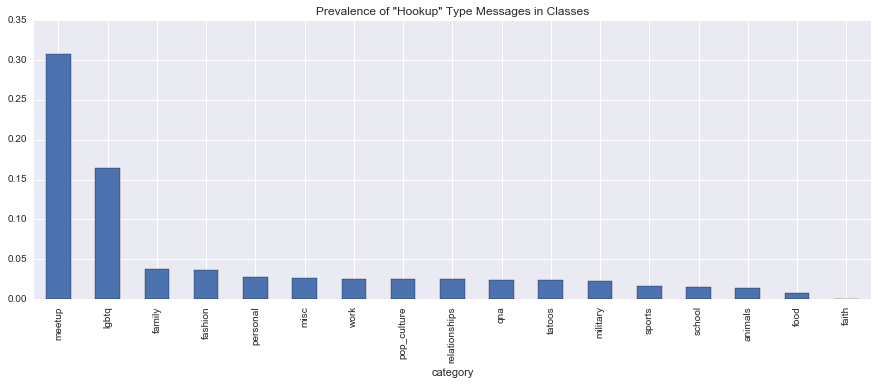

In [116]:

(train.groupby(by='category')['is_hookup'].sum()/train.groupby(by='category').size()).sort_values(ascending=False).plot(kind='bar', 
                                                                                           figsize=(15,5))
plt.title('Prevalence of "Hookup" Type Messages in Classes')

Clearly, the is_hookup flag is a **strong** indicator of "meetup" and "lgbtq" categories.

# 7. Missing Values

In [76]:
train[train['text'].isnull()].sample(10)

,category,text,is_hookup
6047,lgbtq,NaN,NaN
9084,misc,NaN,NaN
11744,misc,NaN,NaN
7057,meetup,NaN,NaN
9319,faith,NaN,NaN
7627,pop_culture,NaN,NaN
12785,misc,NaN,NaN
1455,meetup,NaN,NaN
4228,misc,NaN,NaN
726,misc,NaN,NaN


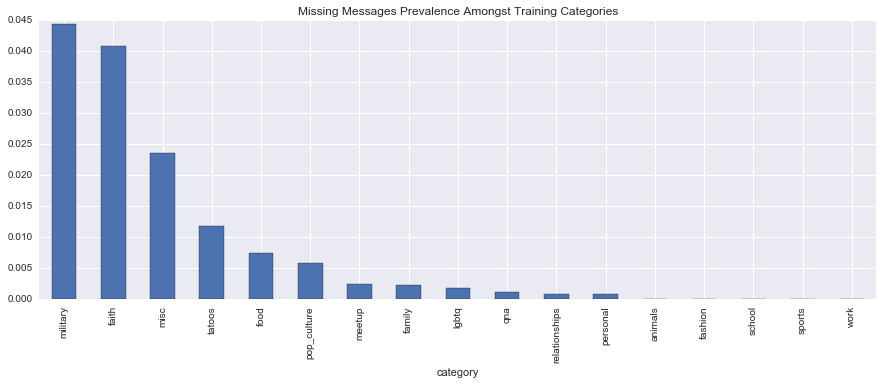

In [115]:
(train[train['text'].isnull()].groupby(by='category').size()/train.groupby(by='category').size()).sort_values(ascending=False).plot(kind='bar',
                                                                                                      figsize=(15,5))
plt.title("Missing Messages Prevalence Amongst Training Categories")

Messages that are missing are much more prevalent in "military", "faith", "misc", and "Tatoos" categories. Instead of dropping, let's mark these strings as "msngval" to indicate missing message. Assuming this is *not* human error, this might serve to indicate a systematic or behavioral anomaly pertaining to these categories. The imputed string should also survive stemming and BOW.

---  

# Result Summary  

I proceed with building a non-parametric model with 6 out of 7 features explored above, concatenated to a Bag Of Words model weighted by Term Document Inverse Document Frequency. Multiple n-grams were tested but didn't make a great deal of difference in the final output, so I stuck with a unigram model. 

Upon training with multiple classifiers (see rough work notebook "Build_Test_Train.ipynb"), Logistic Regression delivers the best performance on a *non-reduced dimensional* space of approximately 7,678 feaetures. The final results are printed below.  

**Run the attached script text_categorizer.py by passing the train and test file paths and names in the following format (note: paths will default to *./../data/train.csv* and *./../data/test.csv* if nothing provided): **  
> text_categorizer.py /filepath/train.csv /filepath/test.csv  


--- 

*Copying outputs (out of sample) on performing a *grid search cross validation* and fitting the best parameters are...*


Best parameters: {'clf_LR__class_weight': 'balanced', 'clf_LR__penalty': 'l2', 'clf_LR__C': 10}

============================================

============================================

OUT OF SAMPLE RESULTS: 

Out of sample Macro F1 Score: 0.531
Classification Report...  

             precision    recall  f1-score   support

    animals       0.56      0.73      0.63        26
      faith       0.36      0.36      0.36        11
     family       0.57      0.78      0.66       110
    fashion       0.30      0.31      0.30        42
       food       0.51      0.65      0.57        63
      lgbtq       0.64      0.67      0.66       147
     meetup       0.76      0.80      0.78       737  
   military       0.78      0.50      0.61        14
       misc       0.52      0.42      0.46       683
   personal       0.57      0.53      0.55       910
pop_culture       0.44      0.36      0.39       150
        qna       0.29      0.43      0.35       221
relationships       0.56      0.54      0.55       337
     school       0.58      0.58      0.58        74
     sports       0.24      0.40      0.30        10
     tatoos       0.70      0.93      0.80        15
       work       0.42      0.55      0.48        49

avg / total       0.57      0.57      0.57      3599



![Out of sample results](./../visuals/oos_results.png)